In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from datetime import datetime
import concurrent.futures
import pickle
from glob import glob

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

In [2]:
train = np.loadtxt("handout/train_triplets.txt", dtype=str, delimiter=" ")

## Data manipulation

451008


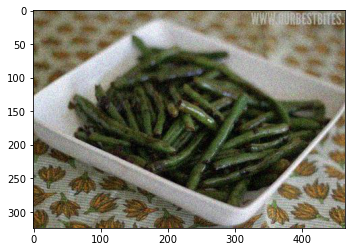

In [3]:
img=mpimg.imread('handout/food/00000.jpg')
print(len(np.ndarray.flatten(img)))
plt.imshow(img);

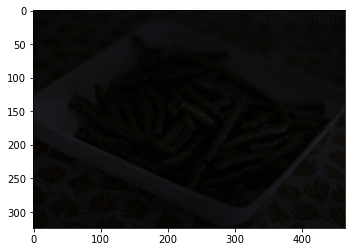

In [4]:
img_norm = tf.keras.utils.normalize(img, axis=1)
plt.imshow(img_norm);

In [3]:
# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows, img_cols, 3)
epochs = 10

def get_image_vector(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape(1, 224, 224, 3)
    return preprocess_input(img)

In [4]:
try:
    with open('features_vg16.pickle', 'rb') as f:
        features_dct = pickle.load(f)
except FileNotFoundError:
    # Pre-trained model to extract features
    model = VGG16(include_top=False, input_tensor=Input(shape=input_shape))
    flat1 = Flatten()(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=flat1)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Preprocess images
    paths = glob('handout/food/*.jpg')
    paths.sort()

    preprocessed_images = {}

    with concurrent.futures.ProcessPoolExecutor() as executor:
        for path in paths:
            key = path.split('/')[-1].replace('.jpg', '')
            preprocessed_images[key] = executor.submit(get_image_vector, path)

    for key, value in preprocessed_images.items():
        preprocessed_images[key] = value.result()

    # Extract features
    features = model.predict(np.concatenate(list(preprocessed_images.values()), axis=0))
    features_dct = {k: v for k, v in zip(preprocessed_images.keys(), features)}

    with open('features_vg16.pickle', 'wb') as f:
        pickle.dump(features_dct, f)

In [5]:
full_rows = []
for row in train:
    full_rows.append(np.hstack([features_dct[n] for n in row]))
train_man = np.vstack(full_rows)

In [6]:
del train_man

In [13]:
if len(train)%2 != 0:
    idx = int((len(train_man) + 1) / 2)
else:
    idx = int(len(train_man) / 2)

train_man_one = train_man[:idx]
train_man_two = train_man[idx:]

sep = int(train_man.shape[1]/3)
t = np.copy(train_man_two[:, sep:(2*sep)])
train_man_two[:, sep:(2*sep)] = train_man_two[:, (2*sep):]
train_man_two[:, (2*sep):] = t

y_labels_one = np.ones(len(train_man_one))
y_labels_two = np.zeros(len(train_man_two))
y_labels = np.hstack([y_labels_one, y_labels_two])
x_train = np.vstack([train_man_one, train_man_two])

X_train, X_test, y_train, y_test = train_test_split(x_train, y_labels, test_size=0.2, random_state=42)

MemoryError: Unable to allocate 16.7 GiB for an array with shape (59515, 75264) and data type float32

## Train

In [12]:
inp = Input(shape=(X_train.shape[1],))
layer = Dense(64, activation=tf.nn.relu, name="Dense1")(inp)
layer = Dense(12, activation=tf.nn.relu, name="Dense2")(layer)
output = Dense(1, activation=tf.nn.sigmoid)(layer)

cl_model = Model(inp, output)
cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'X_train' is not defined

In [132]:
history = cl_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

2022-04-25 10:57:46.812096: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14333878272 exceeds 10% of free system memory.


Epoch 1/40
1488/1488 [==============================] - 28s 18ms/step - loss: 2.8882 - accuracy: 0.5244 - val_loss: 0.6954 - val_accuracy: 0.5035
Epoch 2/40
1488/1488 [==============================] - 22s 15ms/step - loss: 0.6952 - accuracy: 0.5448 - val_loss: 0.6872 - val_accuracy: 0.5567
Epoch 3/40
1488/1488 [==============================] - 22s 15ms/step - loss: 0.6407 - accuracy: 0.5821 - val_loss: 0.6441 - val_accuracy: 0.5890
Epoch 4/40
1488/1488 [==============================] - 23s 15ms/step - loss: 0.5888 - accuracy: 0.6171 - val_loss: 0.6881 - val_accuracy: 0.5746
Epoch 5/40
1488/1488 [==============================] - 22s 15ms/step - loss: 0.5474 - accuracy: 0.6680 - val_loss: 0.6179 - val_accuracy: 0.6574
Epoch 6/40
1488/1488 [==============================] - 24s 16ms/step - loss: 0.5013 - accuracy: 0.7163 - val_loss: 0.6151 - val_accuracy: 0.6852
Epoch 7/40
1488/1488 [==============================] - 23s 16ms/step - loss: 0.4625 - accuracy: 0.7517 - val_loss: 0.5907 -

In [133]:
model.save("models/model_{}".format(datetime.today().strftime('%Y%m%d_%H%M%S')))

INFO:tensorflow:Assets written to: models/model_20220425_112813/assets


In [134]:
# utility functions

def plot_eval(history):
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    ax[0].plot(history.epoch, history.history["loss"], label="training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="validation loss")
    ax[0].legend()
    ax[1].plot(history.epoch, history.history["accuracy"], label="training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="validation accuracy")
    ax[1].legend()
    return fig, ax

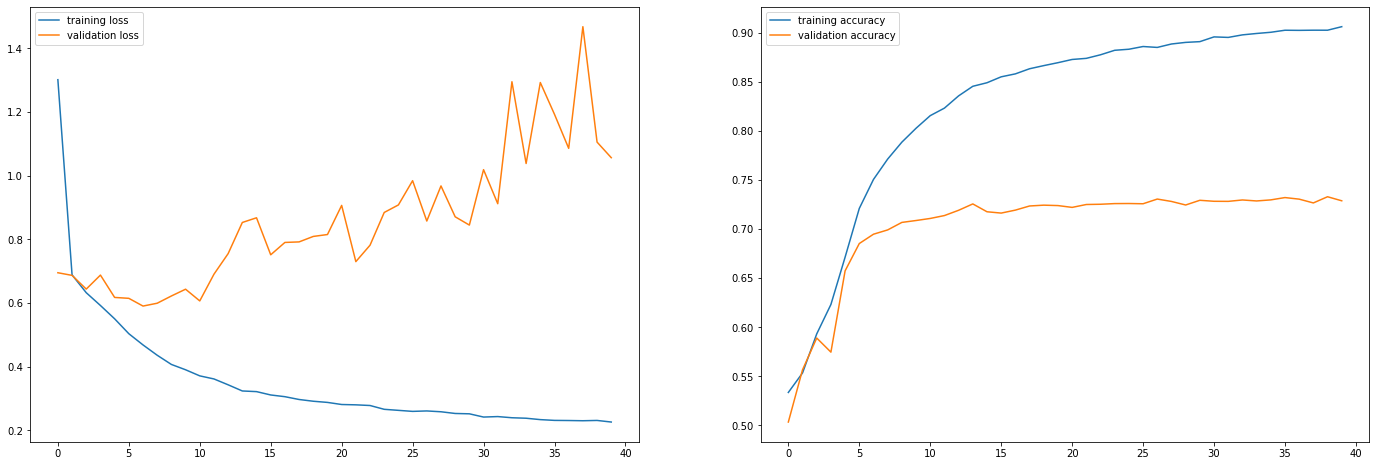

In [135]:
fig, ax = plot_eval(history);